<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import catboost
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from fuzzywuzzy import fuzz

In [4]:
df_vers0 = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")
df = df_vers0.copy()

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [5]:
cols_values = {'experience_level': set(['SE', 'MI', 'EN', 'EX']),
               'employment_type': set(['FT', 'PT', 'CT', 'FL']),
               'remote_ratio': set([0, 50, 100]),
               'company_size': set(['S', 'M', 'L'])}
for key in cols_values:
    extra_values_set = set(df[key].unique()) - cols_values[key]
    extra_values_num = len(extra_values_set)
    if extra_values_num > 0:
        print(f'В столбце {key} есть лишн{'ее' if extra_values_num==1 else 'ие'} значени{'е' if extra_values_num==1 else 'я'}: {str(extra_values_set)[1:-1]}')
    else:
        print(f'В столбце {key} лишних значений нет')

В столбце experience_level лишних значений нет
В столбце employment_type лишних значений нет
В столбце remote_ratio лишних значений нет
В столбце company_size лишних значений нет


In [6]:
set(df['experience_level'].unique()) - cols_values['experience_level']

set()

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [8]:
df.select_dtypes(numerics).describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [9]:
df.select_dtypes(object).describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


Из числовых признаков, 2 на самом деле являются категориальными - work_year и remote_ratio. В столбцах salary и salary_in_usd сильных выбросов нет

В категориальных признаков среди нечисловых проблем нет

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [11]:
categ_cols_list = list(df.select_dtypes(object).columns)
categ_cols_list.append('work_year')
for col in categ_cols_list:
    categories_num = len(df[col].unique())
    print(f'У признака {col} {categories_num} категори{'й' if int(str(categories_num)[-1]) == 0 or int(str(categories_num)[-1]) > 4 else 'и'}')

У признака experience_level 4 категории
У признака employment_type 4 категории
У признака job_title 93 категории
У признака salary_currency 20 категорий
У признака employee_residence 78 категорий
У признака company_location 72 категории
У признака company_size 3 категории
У признака work_year 4 категории


Много категорий у признаков job_title, salary_currency, employee_residence, company_location. employee_residence ниже предложено исключить, по остальным посмотрим на частоту входящих в них категорий:

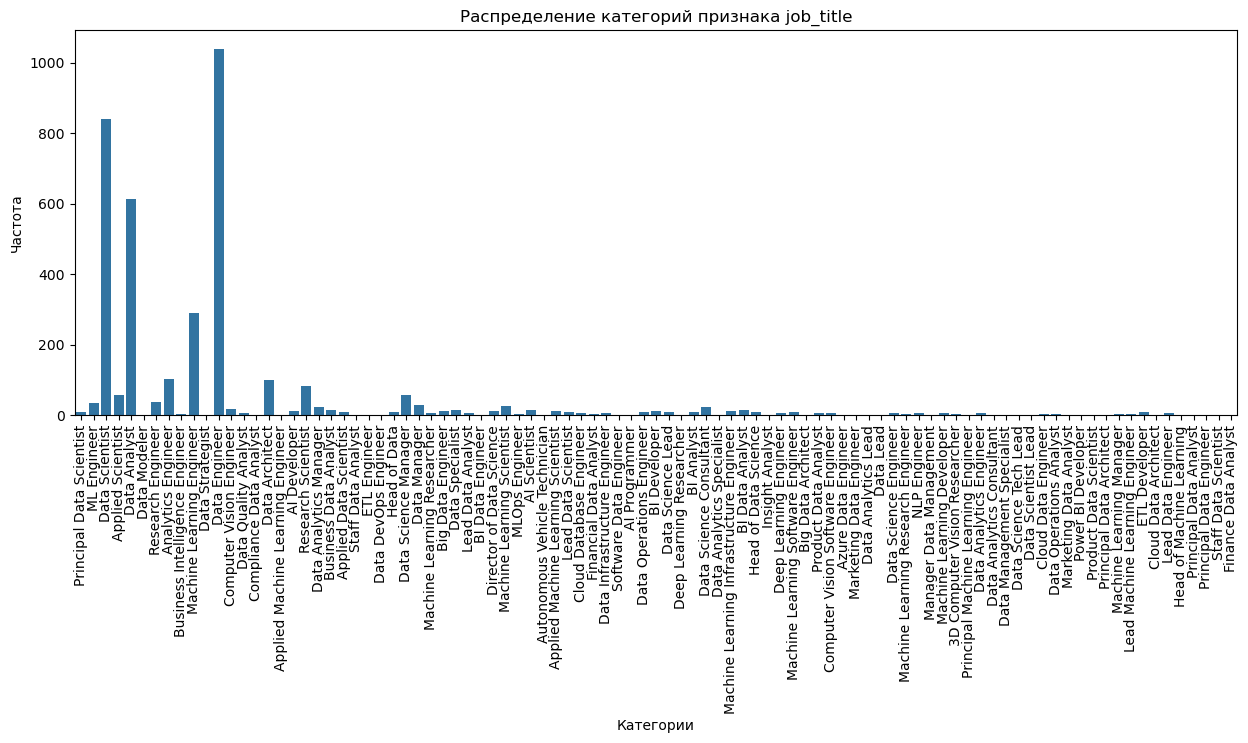

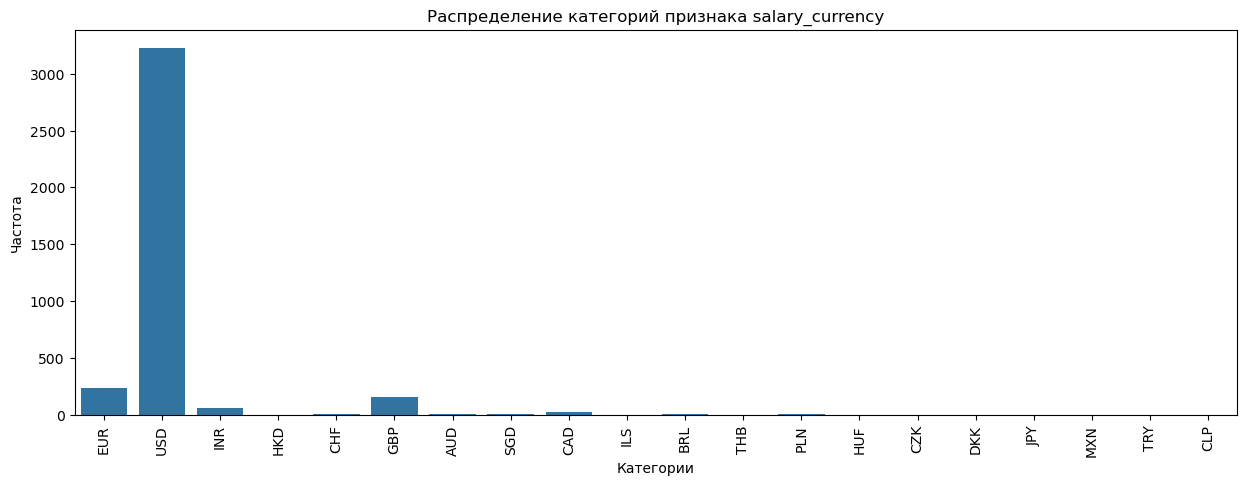

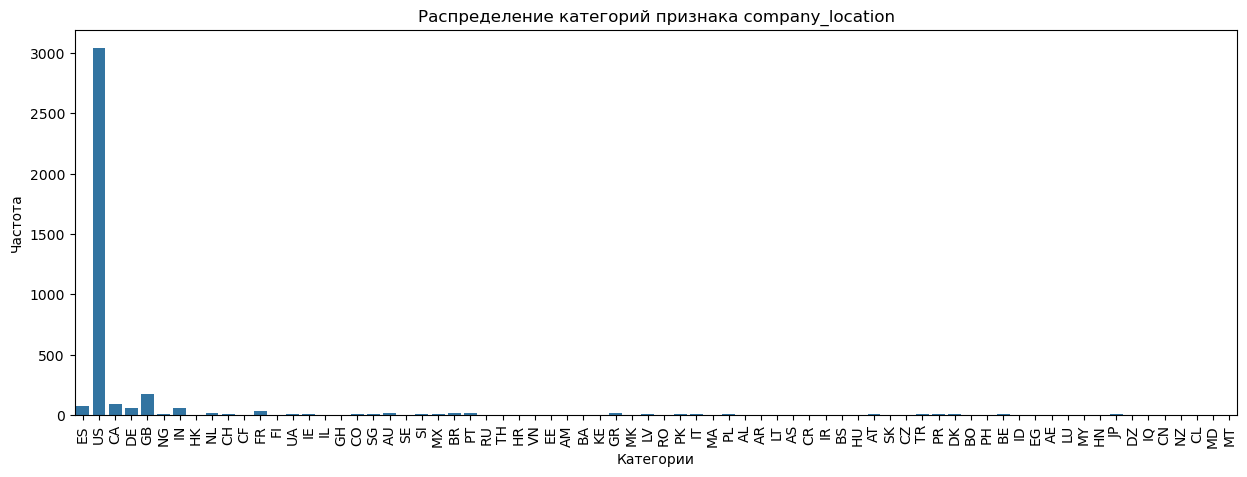

In [12]:
for col in ['job_title', 'salary_currency', 'company_location']:
    plt.figure(figsize=(15, 5))  # Увеличиваем размер графика
    sns.countplot(x=df[col])  # Строим barplot для категориальных данных
    plt.title(f'Распределение категорий признака {col}')
    plt.xlabel('Категории')
    plt.ylabel('Частота')
    plt.xticks(rotation=90)  # Поворачиваем подписи для удобства
    plt.show()

Год, в который взяты данные (признак work_year), несёт в себе информацию об инфляции и актуальности вакансии в текущий момент. Поскольку тестовую часть выборки мы считаем взятыми из настоящего, есть смысл отказаться от данного признака и пересчитать таргет на какой-то один год, либо взять среднее по таргету для каждого года и заменить этим таргет (второе проще)

Зарплата на позиции (признак salary) совместно с валютой, в которой она начисляется (признак salary_currency), несут всю необходимую для таргета информацию, но в таком случае всё это исследование бессмысленно, т.к. с этими признаками нам достаточно иметь доступ к api с курсами валют. При этом саму валюту считаю необходимым оставить, т.к. этот признак может нести информацию о транснациональности компании;

Регион проживания сотрудника (признак employee_residence) не должен повлиять на таргет, т.к. если работа удаленная, то "региональную поправку" несёт местоположение компании (признак company_location), а в случае очной работы, два признака несут одну информацию.

In [14]:
df = df.drop(columns=['salary', 'employee_residence'])
df['work_year'] = df['work_year'].apply(lambda x: df[df['work_year'] == x]['salary_in_usd'].mean())

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [15]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [16]:
train_data_num = train_data.select_dtypes(numerics)
test_data_num = test_data.select_dtypes(numerics)
X_train_num = train_data_num.drop(columns='salary_in_usd')
X_test_num = test_data_num.drop(columns='salary_in_usd')
X_train = train_data.drop(columns='salary_in_usd')
y_train = train_data['salary_in_usd']
X_test = test_data.drop(columns='salary_in_usd')
y_test = test_data['salary_in_usd']

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [17]:
lr = LinearRegression()
lr.fit(X_train_num, y_train)
lr_predict_num = lr.predict(X_test_num)

In [18]:
print(f'Метрики линейной регрессии:\nMAPE - {MAPE(lr_predict_num, y_test)}\nRMSE - {RMSE(lr_predict_num, y_test)}')

Метрики линейной регрессии:
MAPE - 0.35323947546724976
RMSE - 61528.32995226205


Плохая модель, 60000$ - слишком критичное отклонение

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [19]:
cat_regr = CatBoostRegressor(logging_level='Silent')
cat_regr.fit(X_train_num, y_train)
cat_regr_predict_num = cat_regr.predict(X_test_num)

In [20]:
print(f'Метрики CatBoostRegressor:\nMAPE - {MAPE(cat_regr_predict_num, y_test)}\nRMSE - {RMSE(cat_regr_predict_num, y_test)}')

Метрики CatBoostRegressor:
MAPE - 0.3566010969993571
RMSE - 61477.3040438513


Метрики крайне незначительно лучше

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [21]:
df

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,remote_ratio,company_location,company_size
0,149045.541176,SE,FT,Other,EUR,85847,100,ES,L
1,149045.541176,MI,CT,Other,USD,30000,100,US,S
2,149045.541176,MI,CT,Other,USD,25500,100,US,S
3,149045.541176,SE,FT,Data Scientist,USD,175000,100,CA,M
4,149045.541176,SE,FT,Data Scientist,USD,120000,100,CA,M
...,...,...,...,...,...,...,...,...,...
3750,92302.631579,SE,FT,Data Scientist,USD,412000,100,US,L
3751,94087.208696,MI,FT,Other,USD,151000,100,US,L
3752,92302.631579,EN,FT,Data Scientist,USD,105000,100,US,S
3753,92302.631579,EN,CT,Other,USD,100000,100,US,L


In [22]:
df_OHE = df.copy()

train_data_OHE, test_data_OHE = train_test_split(df_OHE, test_size=0.2, random_state=42)

X_train_OHE = train_data_OHE.drop(columns=['salary_in_usd'])
X_test_OHE = test_data_OHE.drop(columns=['salary_in_usd'])

categorical_columns = X_train_OHE.select_dtypes(object).columns
numerical_columns = X_train_OHE.select_dtypes(numerics).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_columns),  # Применяем OneHotEncoder к категориальным столбцам
        ('num', 'passthrough', numerical_columns)  # Оставляем числовые столбцы без изменений
    ]
)

ft_train = preprocessor.fit_transform(X_train_OHE)
X_train_OHE = pd.DataFrame(ft_train, columns=preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist() + numerical_columns.tolist())

ft_test = preprocessor.transform(X_test_OHE)
X_test_OHE = pd.DataFrame(ft_test, columns=preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist() + numerical_columns.tolist())

lr.fit(X_train_OHE, y_train)
lr_predict_OHE = lr.predict(X_test_OHE)
print(f'Метрики линейной регрессии при OHE:\nMAPE - {MAPE(lr_predict_OHE, y_test)}\nRMSE - {RMSE(lr_predict_OHE, y_test)}')

cat_regr.fit(X_train_OHE, y_train)
cat_regr_predict_OHE = cat_regr.predict(X_test_OHE)
print(f'Метрики CatBoostRegressor при OHE:\nMAPE - {MAPE(cat_regr_predict_OHE, y_test)}\nRMSE - {RMSE(cat_regr_predict_OHE, y_test)}')

Метрики линейной регрессии при OHE:
MAPE - 0.3390893515263193
RMSE - 48857.64130448107
Метрики CatBoostRegressor при OHE:
MAPE - 0.3068098182825937
RMSE - 49053.184119057034


In [23]:
le = LabelEncoder()
X_train_LE = X_train.copy()
X_test_LE = X_test.copy()
for col in X_train_LE.select_dtypes(object):
    X_train_LE[col] = le.fit_transform(X_train_LE[col])
    X_test_LE[col] = le.transform(X_test_LE[col])

lr.fit(X_train_LE, y_train)
lr_predict_LE = lr.predict(X_test_LE)
print(f'Метрики линейной регрессии при LabelEncoding:\nMAPE - {MAPE(lr_predict_LE, y_test)}\nRMSE - {RMSE(lr_predict_LE, y_test)}')

cat_regr.fit(X_train_LE, y_train)
cat_regr_predict_LE = cat_regr.predict(X_test_LE)
print(f'Метрики CatBoostRegressor при LabelEncoding:\nMAPE - {MAPE(cat_regr_predict_LE, y_test)}\nRMSE - {RMSE(cat_regr_predict_LE, y_test)}')

Метрики линейной регрессии при LabelEncoding:
MAPE - 0.37283791298436647
RMSE - 52856.756399824844
Метрики CatBoostRegressor при LabelEncoding:
MAPE - 0.3202284266219998
RMSE - 48685.326520454735


In [24]:
train_data_MT = train_data.copy()
test_data_MT = test_data.copy()
for col in train_data_MT.select_dtypes(object):
    train_data_MT[col] = train_data_MT[col].apply(lambda x: train_data_MT[train_data_MT[col] == x]['salary_in_usd'].mean())
    test_data_MT[col] = test_data_MT[col].apply(lambda x: test_data_MT[test_data_MT[col] == x]['salary_in_usd'].mean())

X_train_MT = train_data_MT.drop(columns=['salary_in_usd'])
X_test_MT = test_data_MT.drop(columns=['salary_in_usd'])

lr.fit(X_train_MT, y_train)
lr_predict_MT = lr.predict(X_test_MT)
print(f'Метрики линейной регрессии при MeanTargerEnc:\nMAPE - {MAPE(lr_predict_MT, y_test)}\nRMSE - {RMSE(lr_predict_MT, y_test)}')

cat_regr.fit(X_train_MT, y_train)
cat_regr_predict_MT = cat_regr.predict(X_test_MT)
print(f'Метрики CatBoostRegressor при MeanTargerEnc:\nMAPE - {MAPE(cat_regr_predict_MT, y_test)}\nRMSE - {RMSE(cat_regr_predict_MT, y_test)}')

Метрики линейной регрессии при MeanTargerEnc:
MAPE - 0.31348899287893167
RMSE - 48896.45462938537
Метрики CatBoostRegressor при MeanTargerEnc:
MAPE - 0.3553981387547149
RMSE - 48803.65826842224


## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [25]:
test_data_for_check = test_data.copy()
test_data_for_check['error'] = (lr_predict_OHE - y_test).abs()

In [26]:
test_data_for_check.nlargest(20, 'error')

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,remote_ratio,company_location,company_size,error
1288,149045.541176,SE,FT,Data Analyst,USD,385000,0,US,M,255947.246348
2359,133338.620793,SE,FT,Other,USD,375000,50,US,L,208472.528399
1105,149045.541176,SE,FT,Data Scientist,USD,370000,0,US,M,206456.444251
183,92302.631579,EX,FT,Other,USD,15000,0,CA,M,182785.981065
33,149045.541176,SE,FT,Other,USD,342810,0,US,M,179626.636877
3609,92302.631579,SE,FT,Other,USD,260000,0,Other,S,176948.837095
1116,149045.541176,SE,FT,Machine Learning Engineer,USD,323300,0,US,M,145792.626203
478,149045.541176,EX,FT,Other,USD,353200,0,US,M,143128.076335
1593,149045.541176,SE,FT,Data Engineer,USD,300000,0,US,M,141209.512986
2009,133338.620793,SE,FT,Machine Learning Engineer,USD,255000,100,Other,M,134575.503438


**Ваш ответ здесь**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [27]:
test_fuzz = test_data_for_check.copy()

In [28]:
base_title = 'Data Scientist'

In [29]:
for year in test_fuzz['work_year'].unique():
    test_fuzz[f'job_title_similarity_ratio_{year}'] = test_fuzz.apply(
        lambda row: fuzz.ratio(row['job_title'], base_title)
        if row['work_year'] == year else 0, axis=1)


In [30]:
test_fuzz

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,remote_ratio,company_location,company_size,error,job_title_similarity_ratio_133338.62079326922,job_title_similarity_ratio_149045.54117647058,job_title_similarity_ratio_94087.20869565217,job_title_similarity_ratio_92302.63157894737
2148,133338.620793,SE,FT,Other,USD,168000,100,CA,M,9368.632340,21,0,0,0
1044,149045.541176,SE,FT,Data Analyst,USD,179975,100,US,M,50952.478580,0,62,0,0
3321,133338.620793,SE,FT,Data Scientist,USD,144000,100,US,M,16541.509031,100,0,0,0
439,149045.541176,SE,FT,Applied Scientist,USD,222200,0,US,L,22045.531706,0,65,0,0
3519,94087.208696,EX,FT,Other,USD,230000,50,Other,L,78091.328350,0,0,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,133338.620793,SE,FT,Data Analyst,USD,105000,0,US,M,21080.939166,62,0,0,0
2897,133338.620793,SE,FT,Data Scientist,USD,141525,100,US,M,19016.509031,100,0,0,0
612,149045.541176,EN,FT,Data Engineer,USD,58000,100,US,M,53953.562030,0,52,0,0
2677,133338.620793,SE,FT,Data Analyst,EUR,36773,0,ES,M,727.484266,62,0,0,0


In [ ]:
# Ваш код здесь

**Ваш ответ здесь**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [34]:
param_dist = {
    'iterations': np.arange(100, 3000, 500),  # Количество итераций
    'learning_rate': np.arange(0.01, 0.1, 0.01),  # Скорость обучения
    'depth': np.arange(3, 15, 1),  # Глубина дерева
    'l2_leaf_reg': np.arange(1, 10, 2),  # Коэффициент L2-регуляризации
    'border_count': np.arange(16, 256, 16),  # Количество границ для числовых признаков
    'random_strength': np.arange(0.1, 1, 0.1),  # Сила случайности
    'bagging_temperature': np.arange(0, 1, 0.1),  # Температура бэггинга
}

cb_model = CatBoostRegressor(task_type='GPU')

# Настройка RandomizedSearchCV
rs_catboost = RandomizedSearchCV(
    estimator=cb_model,
    param_distributions=param_dist,
    n_iter=10,  # Количество итераций случайного поиска
    cv=3,  # Количество фолдов кросс-валидации
    scoring='neg_mean_squared_error',  # Метрика для оптимизации
    random_state=42, 
    verbose=1
)

# Запуск поиска
rs_catboost.fit(X_train_OHE, y_train)

# Лучшие гиперпараметры
print("Лучшие гиперпараметры:", rs_catboost.best_params_)

# Лучшая модель
best_model = rs_catboost.best_estimator_

# Предсказание на тестовых данных
y_pred_rs_catboost = best_model.predict(X_test_OHE)

# Оценка качества модели
print(f'Метрики CatBoostRegressor при MeanTargerEnc:\nMAPE - {MAPE(y_pred_rs_catboost, y_test)}\nRMSE - {RMSE(y_pred_rs_catboost, y_test)}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 62900.4519114	total: 7.07ms	remaining: 11.3s
1:	learn: 62700.9650416	total: 12.9ms	remaining: 10.3s
2:	learn: 62512.8741502	total: 20.6ms	remaining: 11s
3:	learn: 62327.7808513	total: 26.5ms	remaining: 10.6s
4:	learn: 62145.6445047	total: 33.7ms	remaining: 10.7s
5:	learn: 61973.7048693	total: 39.6ms	remaining: 10.5s
6:	learn: 61784.1290305	total: 45.3ms	remaining: 10.3s
7:	learn: 61599.3585685	total: 51.1ms	remaining: 10.2s
8:	learn: 61430.3832634	total: 56.9ms	remaining: 10.1s
9:	learn: 61256.8977239	total: 65ms	remaining: 10.3s
10:	learn: 61094.2412259	total: 73.1ms	remaining: 10.6s
11:	learn: 60933.0136706	total: 80ms	remaining: 10.6s
12:	learn: 60759.8643825	total: 85.7ms	remaining: 10.5s
13:	learn: 60589.5571081	total: 92.3ms	remaining: 10.4s
14:	learn: 60428.2246390	total: 98.6ms	remaining: 10.4s
15:	learn: 60277.4444671	total: 104ms	remaining: 10.3s
16:	learn: 60127.1812368	total: 110ms	remaining: 10.3s
17:	l

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [39]:
xgb_model = xgb.XGBRegressor(tree_method='hist', device='cuda')

xgb_params = {
            'n_estimators': np.arange(50, 1000, 100),
            'max_depth': np.arange(3, 8, 1),
            'learning_rate': np.arange(0.01, 0.2, 0.02),
            'subsample': np.arange(0.5, 1, 0.1),
            'colsample_bytree': np.arange(0.5, 1, 0.1)
            }

rs_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=50,  # Количество итераций
    cv=3,  # Количество фолдов кросс-валидации
    random_state=42,
    verbose=1,
    scoring='neg_mean_squared_error'
)

rs_xgb.fit(X_train_OHE, y_train)

# Лучшая модель
best_model_xgb = rs_xgb.best_estimator_

# Предсказание на тестовых данных
y_pred_rs_xgb = best_model_xgb.predict(X_test_OHE)

# Оценка качества модели
print(f'Метрики XGBoost с подобранными гиперпараметрами:\nMAPE - {MAPE(y_pred_rs_catboost, y_test)}\nRMSE - {RMSE(y_pred_rs_catboost, y_test)}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Метрики XGBoost с подобранными гиперпараметрами:
MAPE - 0.28455646610040475
RMSE - 47957.28155935459


In [40]:
print("Лучшие гиперпараметры:", rs_xgb.best_params_)
print(f'Метрики XGBoost с подобранными гиперпараметрами:\nMAPE - {MAPE(y_pred_rs_xgb, y_test)}\nRMSE - {RMSE(y_pred_rs_xgb, y_test)}')

Лучшие гиперпараметры: {'subsample': 0.6, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.7}
Метрики XGBoost с подобранными гиперпараметрами:
MAPE - 0.27878664375930534
RMSE - 48189.766264960905


## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

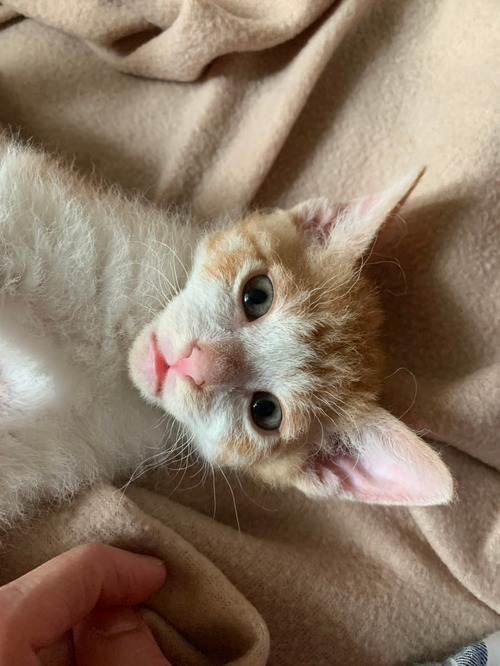